SkimLit: Let's make [PubMed](https://pubmed.ncbi.nlm.nih.gov/) abstracts easier to read 

Pubmed is a platform where we can find millions of articles in medical fields

The purpose of this project is to build an NLP model to make reading medical abtracts easier.

Goal: Replicate the [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071) paper

(model structure avalaible here https://arxiv.org/pdf/1612.05251.pdf)

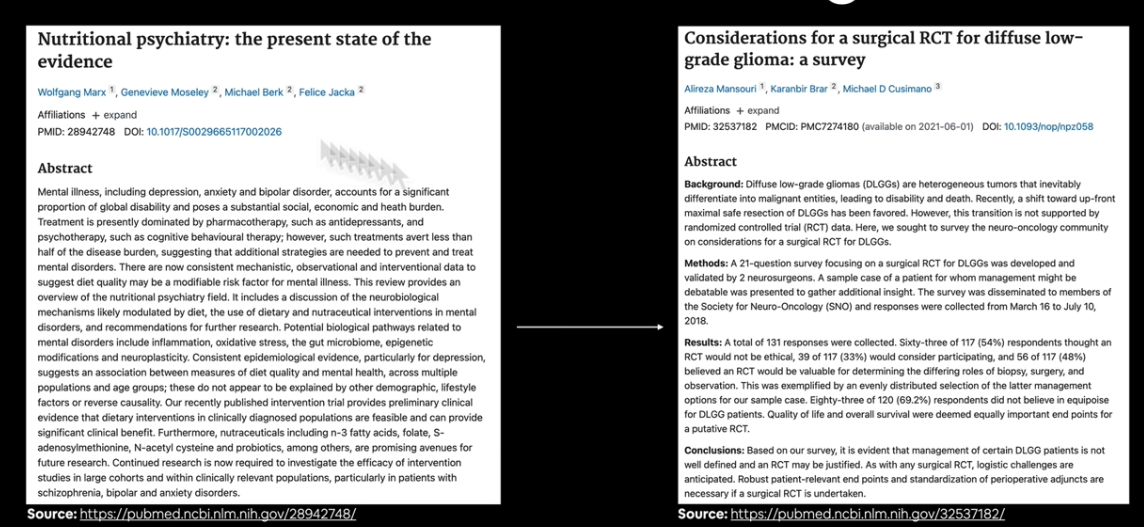

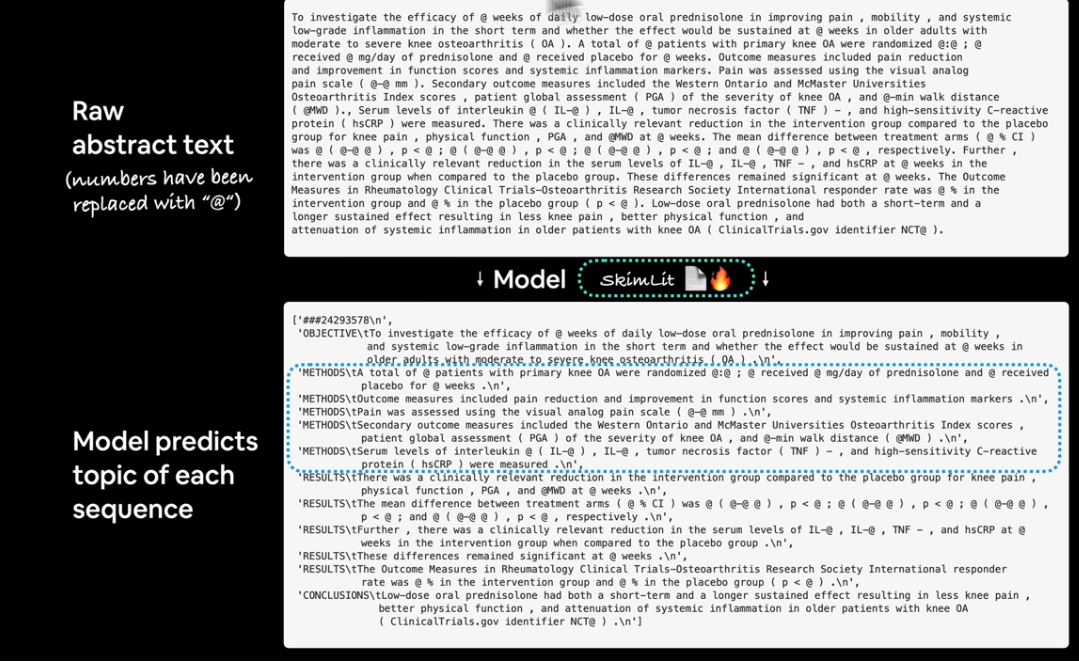

Classifing sentences in the abstract.

It's a many to one sequence problem

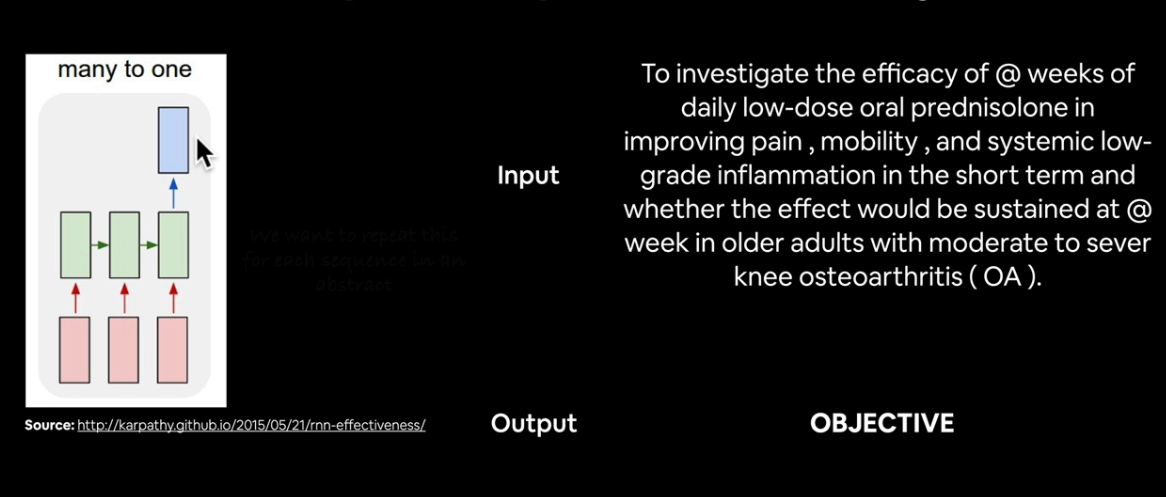

#### Steps:

    - Get the data
    - Preprocess our data
    - Replicate the model described in the paper (Multimodal model (model that takedifferent sources of data))

#### Inputs and Output

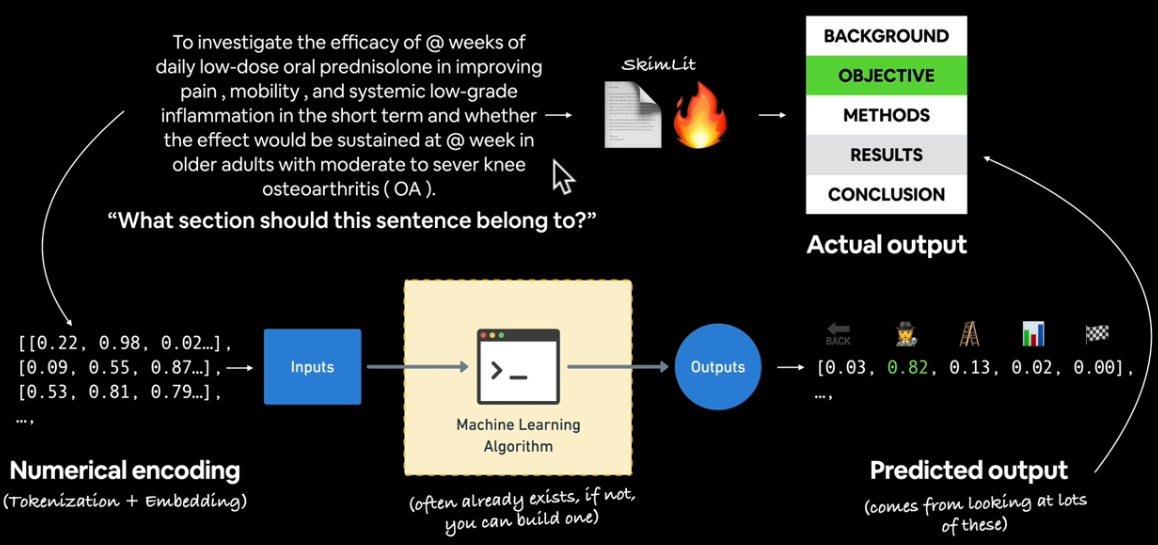

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_hub as hub
import string
from keras.utils import plot_model

### Get one with the data

In [2]:
train_df = pd.read_csv('/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.csv')
valid_df = pd.read_csv('/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.csv')
test_df = pd.read_csv('/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.csv')

In [3]:
train_df.head()

,abstract_id,line_id,abstract_text,line_number,total_lines,target
0,24293578,24293578_0_12,To investigate the efficacy of @ weeks of dail...,0,12,OBJECTIVE
1,24293578,24293578_1_12,A total of @ patients with primary knee OA wer...,1,12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,METHODS


In [4]:
print('Number of samples in train data: ', train_df.shape[0])
print('Number of samples in validation data: ', valid_df.shape[0])

Number of samples in train data:  180040
Number of samples in validation data:  30212


Text(0.5, 1.0, 'Target distribution')

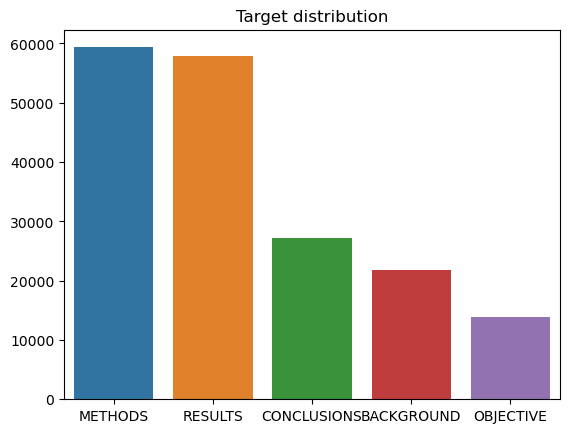

In [5]:
# visualise target distribution
target_counts = train_df.target.value_counts()
target_counts
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Target distribution')

Text(0.5, 1.0, 'Number of sentences per abstract')

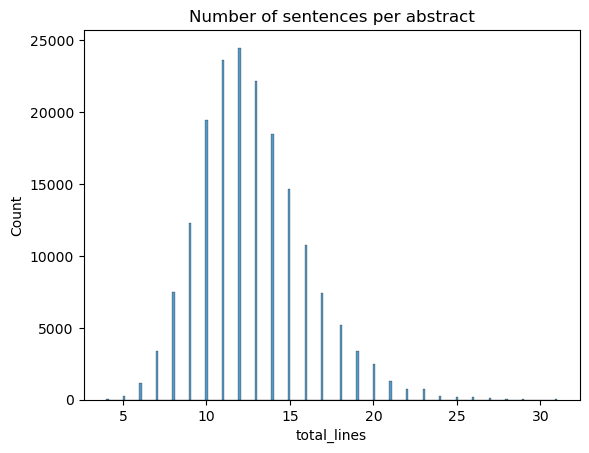

In [6]:
# Check the lenght of different sentences
sns.histplot(train_df.total_lines)
plt.title('Number of sentences per abstract')

In [7]:
# Get sentences length distributon
sentence_len = [len(sentence.split()) for sentence in train_df['abstract_text'].tolist()]
avg_len = np.mean(sentence_len)
avg_len

26.338269273494777

Text(0.5, 1.0, 'sentences length distributon')

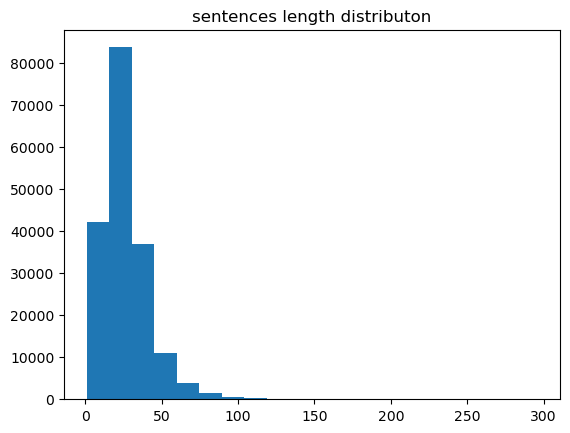

In [8]:
plt.hist(sentence_len, bins=20)
plt.title('sentences length distributon')

In [26]:
train_data = train_df['abstract_text'].tolist()
valid_data = valid_df['abstract_text'].tolist()
test_data = test_df['abstract_text'].tolist()

In [10]:
# Convert our labels into numerical format
one_hot_encoder = OneHotEncoder(sparse_output=False) # we want non-sparse matrix (sparse matrix is a matrix in which most of the elements are 0)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1, 1))
valid_labels_one_hot = one_hot_encoder.transform(valid_df.target.to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1, 1))

In [11]:
# label encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df.target.to_numpy())
valid_labels_encoded = label_encoder.transform(valid_df.target.to_numpy())
test_labels_encoded = label_encoder.transform(test_df.target.to_numpy())

In [12]:
# Get class names
class_names = label_encoder.classes_
print(class_names)

['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


In [13]:
# How long of a sentence length covers 95% of data
output_seq_len = int(np.percentile(sentence_len, 95))
output_seq_len

55

#### Create a text vectorizer

In [14]:
max_tokens = 68000

In [15]:
text_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_seq_len
)

In [16]:
# apdapt text vectorizer to the training sentences
text_vectorizer.adapt(train_data)

In [17]:
text_vocab = text_vectorizer.get_vocabulary()
print('Number of words in vocab: ', len(text_vocab))
print('5 most common words: ', text_vocab[:5])
print('5 least common words: ', text_vocab[-5:])

Number of words in vocab:  64841
5 most common words:  ['', '[UNK]', 'the', 'and', 'of']
5 least common words:  ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [19]:
# create token embedding layer
token_emb = tf.keras.layers.Embedding(
    input_dim=len(text_vocab),
    output_dim=128,
    mask_zero=True,
    name='token_embedding'
)

In [22]:
len(train_data), train_labels_one_hot.shape


(180040, (180040, 5))

In [27]:
# make sure tensorflow brocess the data as fastest as possible by creating a dataset with tf.data API
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_data, valid_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels_one_hot))

In [28]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

The paper use Glove Embeddings, however i used the later created USE pretrained embeddings

In [30]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
   input_shape=[],
   trainable=False,
   dtype=tf.string,
   name='USE'
)

#### Create character level embedding

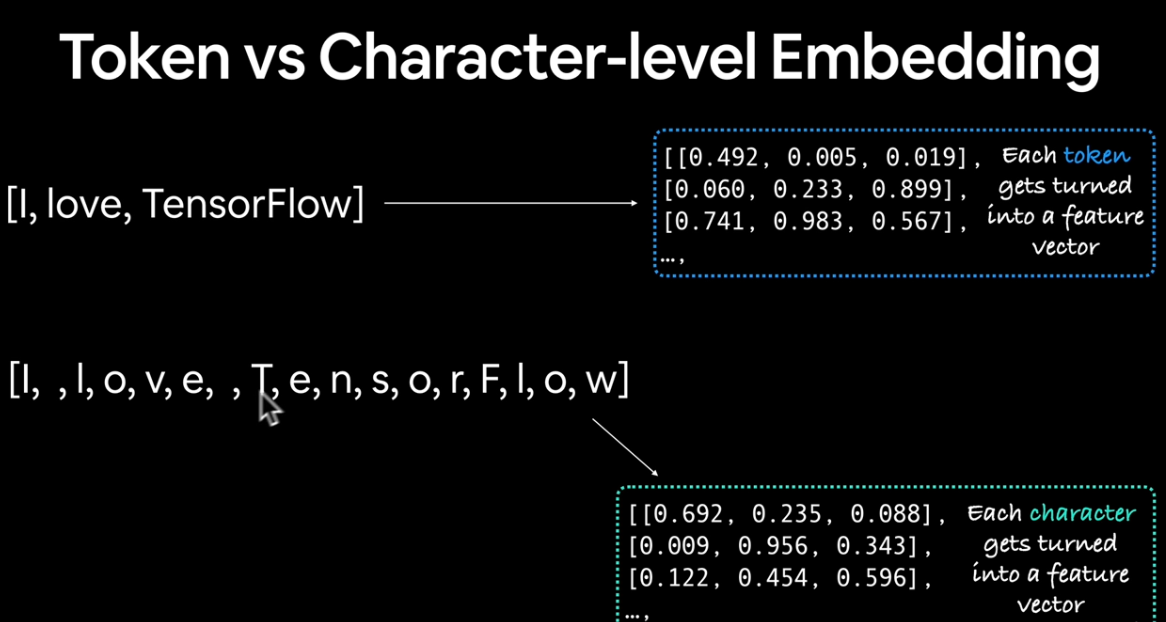

In [31]:
# function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

In [35]:
train_chars = [split_chars(sentence) for sentence in train_data]
valid_chars = [split_chars(sentence) for sentence in valid_data]
test_chars = [split_chars(sentence) for sentence in test_data]

In [38]:
# Get sentences length distributon
char_len = [len(sentence) for sentence in train_data]
avg_char_len = np.mean(char_len)
avg_char_len

149.3662574983337

In [39]:
# find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

In [41]:
# get all keyboars characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [42]:
num_char_tokens = len(alphabet) + 2 # 2 for space and OOV or [UNK]
char_vectorizer = TextVectorization(
    max_tokens=num_char_tokens,
    output_sequence_length=output_seq_char_len,
#     standardize=None, # set it you want to leave punctuation in 
    name='char_vectorizer'  
)

In [43]:
char_vectorizer.adapt(train_chars)

In [44]:
char_vocab = char_vectorizer.get_vocabulary()
print('Number of characters in vocab: ', len(char_vocab))
print('5 most common characters: ', char_vocab[:5])
print('5 least common characters: ', char_vocab[-5:])

Number of characters in vocab:  28
5 most common characters:  ['', '[UNK]', 'e', 't', 'i']
5 least common characters:  ['k', 'x', 'z', 'q', 'j']


In [45]:
# create token embedding layer
char_emb = tf.keras.layers.Embedding(
    input_dim=len(char_vocab),
    output_dim=25,
    mask_zero=True,
    name='char_embedding'
)

In [51]:
# make sure tensorflow brocess the data as fastest as possible by creating a dataset with tf.data API
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
valid_char_dataset = tf.data.Dataset.from_tensor_slices((valid_chars, valid_labels_one_hot))
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

In [52]:
train_char_dataset = train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = valid_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

Steps:

    - Create a token-level embedding model
    - Create a character-level embedding model
    - Combine 1 and 2 with (tf.keras.Concatenate)
    - Build a series of output layers on top of 3 (as described in the papaer fig1 and section 4.2) (https://arxiv.org/pdf/1612.05251.pdf)
    - construct a model which takes token and character-level sequences as input and produce label probabilities as output.

In [59]:
# 1- Create a token-level embedding model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(300, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2- Create a character-level embedding model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype="string", name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_emb(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3- Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = tf.keras.layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 4- Create output layers adding in Droupout as discussed in the paper
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat) # set 50% of the input to 0
combined_bi_lstm =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(tf.expand_dims(combined_dropout, axis=1))
final_dropout = tf.keras.layers.Dropout(0.5)(combined_bi_lstm)
output_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')(final_dropout)

# 5- Construct model with char and token input
model = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer, name='final_model')


In [60]:
model.summary()

Model: "final_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_input[0][0]']  

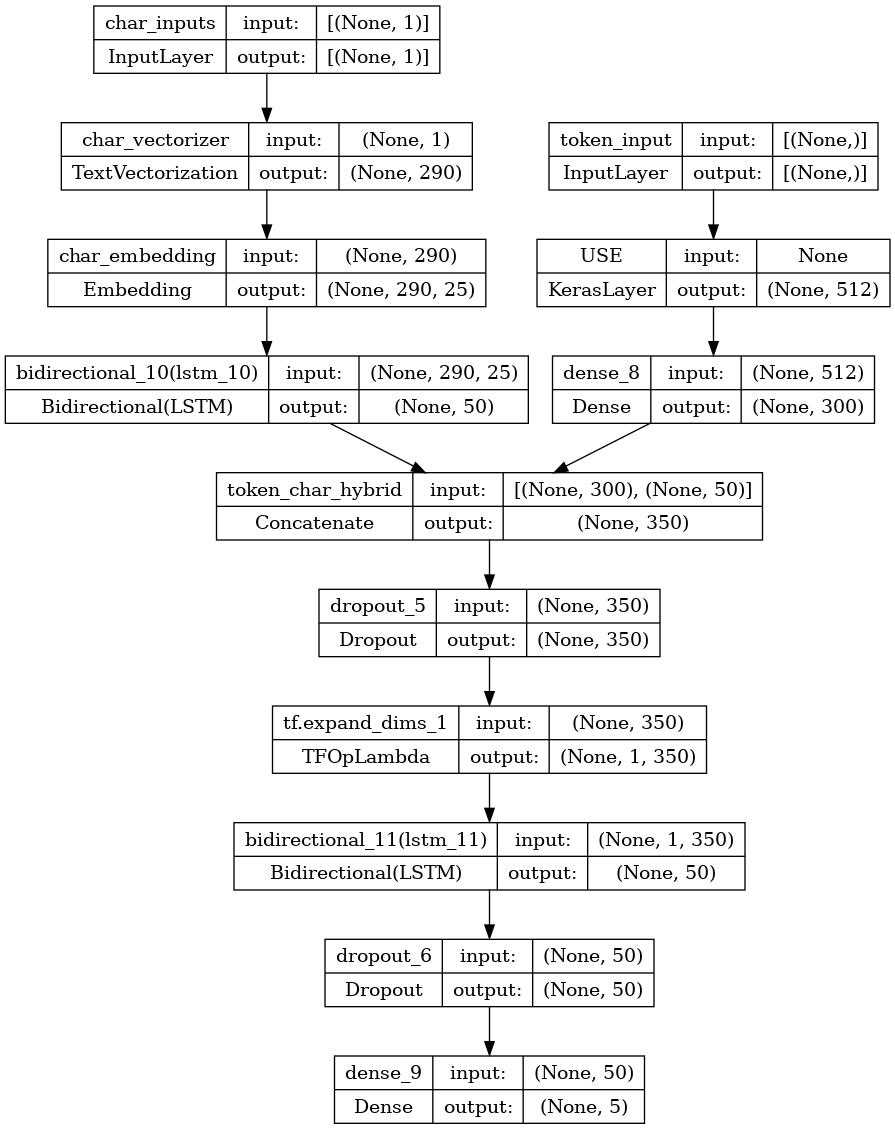

In [62]:
# visualise our model
plot_model(model, show_shapes=True)

In [63]:
# Compile model
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [64]:
# combine chars and tokens into a dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_data, train_chars)) # make data
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels)) # combine data and labels

train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [72]:
# combine chars and tokens into a dataset
valid_token_char_data = tf.data.Dataset.from_tensor_slices((valid_data, valid_chars)) # make data
valid_token_char_labels = tf.data.Dataset.from_tensor_slices(valid_labels_one_hot) # make labels
valid_token_char_dataset = tf.data.Dataset.zip((valid_token_char_data, valid_token_char_labels)) # combine data and labels

valid_token_char_dataset = valid_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [71]:
# Fit the model
history = model.fit(train_token_char_dataset,
                        epochs=5,
                        validation_data=valid_token_char_dataset
                        )

Epoch 1/5
5627/5627 [==============================] - 342s 57ms/step - loss: 0.2736 - accuracy: 0.7079 - val_loss: 0.2217 - val_accuracy: 0.7611
Epoch 2/5
5627/5627 [==============================] - 297s 53ms/step - loss: 0.2341 - accuracy: 0.7541 - val_loss: 0.2092 - val_accuracy: 0.7774
Epoch 3/5
5627/5627 [==============================] - 298s 53ms/step - loss: 0.2243 - accuracy: 0.7666 - val_loss: 0.2033 - val_accuracy: 0.7817
Epoch 4/5
5627/5627 [==============================] - 299s 53ms/step - loss: 0.2175 - accuracy: 0.7746 - val_loss: 0.1992 - val_accuracy: 0.7860
Epoch 5/5
5627/5627 [==============================] - 299s 53ms/step - loss: 0.2135 - accuracy: 0.7795 - val_loss: 0.1957 - val_accuracy: 0.7911
